# Dependencias

In [72]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import sys
import os 
ruta_carpeta = os.path.abspath('../src')
if ruta_carpeta not in sys.path:
    sys.path.append(ruta_carpeta)
import utilidades as ut
import numpy as np
import utilidades_regex as ur
import igraph as ig
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from itertools import combinations
from scipy.stats import pearsonr
import h5py
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import re
from collections import Counter

# lectura de los datos 

In [2]:
data_grafo = pd.read_json("../input/base_final.json")
data_represntantes = pd.read_csv("../input/representantes_total.csv")

In [3]:
data_grafo.head(1).values

array([['INDUSTRIA Y COMERCIO',
        'Por medio del cual el impuesto de industria y comercio por la explotación de recursos\nnaturales no renovables de hidrocarburos y minerales, es compatible con el pago de regalías por asignaciones directas que reciben los municipios productores y se dictan otras disposiciones',
        '001/2022C', None,
        list(['HR. Juan Diego Muñoz Cabrera', 'HR. Julián Peinado Ramírez']),
        'http://svrpubindc.imprenta.gov.co/senado/index2.xhtml?ent=Cámara&fec=26-7-2022&num=857',
        'https://www.camara.gov.co/industria-y-comercio', '2022 - 2023',
        'Archivado', 'Ley Ordinaria',
        list(['Partido Liberal', 'Partido Alianza Verde'])]], dtype=object)

In [4]:
data_represntantes.head(1).values

array([['Adriana Carolina Arbeláez Giraldo', 'Bogotá', 'Cambio Radical',
        'carolina.arbelaez@camara.gov.co',
        '512 - 513 - Edificio Nuevo del Congreso',
        '+(57) (601) 8770720 Ext: 3545',
        'https://www.facebook.com/CaroArbelaezGiraldo',
        'https://twitter.com/kroarbelaez',
        'https://www.youtube.com/@carolinaarbelaez9271',
        'https://www.instagram.com/caroarbelaezg/']], dtype=object)

# grafico de barras para partido

In [5]:
# generar grafico de barras

fig = px.histogram(data_represntantes, x='Partido', title='Conteo de representantes por partido',)
fig.write_html("../output/histograma_partidos_politicos_plotly.html")

In [6]:
n_leyes = data_grafo.explode('Partidos')['Partidos'].value_counts()
# grafico de barras para el numero de leyes por partido 
fig = go.Figure(data=[go.Bar(
            x=n_leyes.index, y=n_leyes.values,
            text=n_leyes.values,
            textposition='auto',
            marker_color='rgb(158,202,225)'
        )])
fig.write_html("../output/histograma_leyes_partidos_plotly.html")

# creacion de las redes

In [7]:
data_grafo.loc[0]

Seudonimo                                           INDUSTRIA Y COMERCIO
Titulo                 Por medio del cual el impuesto de industria y ...
No Camara                                                      001/2022C
No Senado                                                           None
Autores                [HR. Juan Diego Muñoz Cabrera, HR. Julián Pein...
Link Transcripción     http://svrpubindc.imprenta.gov.co/senado/index...
Link Web                  https://www.camara.gov.co/industria-y-comercio
Periodo Legislativo                                          2022 - 2023
Estado                                                         Archivado
Tipo                                                       Ley Ordinaria
Partidos                        [Partido Liberal, Partido Alianza Verde]
Name: 0, dtype: object

In [8]:
# creacion de nodos
# nodo ley
nodos_leyes = list(data_grafo['No Camara'].values)
print(len(nodos_leyes))
# nodo partido 
nodos_partidos = list(data_grafo['Partidos'].explode().unique())
print(len(nodos_partidos))
# nodo representante
nodos_autores = list(data_grafo['Autores'].explode().unique())
print(len(nodos_autores))

730
38
217


## grafos bipartitos 

ley partido
ley representantes

In [9]:
# grafo de leyes autores
g_la = ig.Graph()
# grafo de leyes partidos
g_lp = ig.Graph()

In [10]:
# agregar nodos 
g_la.add_vertices(nodos_leyes + nodos_autores)
g_lp.add_vertices(nodos_leyes + nodos_partidos)

In [11]:
# agregamos las aristas 
# funcion para agregar al grafo las aristas desde el df 
def agregar_aristas(row, g, columna):
    nodo_origen = row['No Camara']
    for nodo_destino in row[columna]:
        g.add_edge(nodo_origen, nodo_destino)

data_grafo.apply(lambda row:agregar_aristas( row, g=g_la, columna='Autores'), axis=1)
data_grafo.apply(lambda row:agregar_aristas( row, g=g_lp, columna='Partidos'), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
727    None
728    None
729    None
730    None
731    None
Length: 730, dtype: object

In [12]:
# añadimos el tipo de nodo a cada nodo para que se tomen como bipartitos
tipo_la = [False for i in range(len(nodos_leyes))] + [True for i in range(len(nodos_autores))]
tipo_lp = [False for i in range(len(nodos_leyes))] + [True for i in range(len(nodos_partidos))]
print(len(tipo_la), len(tipo_lp))
g_la.vs['type'] = tipo_la
g_lp.vs['type'] = tipo_lp

947 768


In [13]:
# generacion de graficos
fig  = ut.generargrafico(g_lp, 'Grafo para leyes y autores', 'fr')
fig.write_html("../output/grafico_bipartito_partidos_leyes.html")

## generacion de proyecciones

In [14]:
# proyeccion de los grafos
def optener_proyecciones(G):
    # matriz de adyasencia
    A = np.array(G.get_biadjacency()[0]) 
    leyes = G.vs.select(type=False)['name'] # nodos de leyes
    otro_grupo = G.vs.select(type=True)['name']
    A_A_t = np.dot(A, A.T)
    A_t_A = np.dot(A.T, A)
    np.fill_diagonal(A_A_t, 0)
    np.fill_diagonal(A_t_A, 0)
    return A_A_t, A_t_A, leyes,otro_grupo

In [15]:
Ad_leyes_1,Ad_autores,leyes,autores= optener_proyecciones(g_la)
Ad_leyes_2,Ad_partidos,leyes,partidos= optener_proyecciones(g_lp)

In [16]:
G_leyes = ut.grafo_matriz_adyacencia(Ad_leyes_1, leyes)
G_autores = ut.grafo_matriz_adyacencia(Ad_autores, autores)
G_partidos = ut.grafo_matriz_adyacencia(Ad_partidos, partidos)

In [17]:
print(G_leyes.summary(),"\n",G_autores.summary(),"\n",G_partidos.summary())

IGRAPH UNW- 730 56349 -- 
+ attr: name (v), weight (e) 
 IGRAPH UNW- 217 13693 -- 
+ attr: name (v), weight (e) 
 IGRAPH UNW- 38 555 -- 
+ attr: name (v), weight (e)


# Analisis de proyecciones

In [18]:
def grafico_grafos_simples(g,title, layout):
    # Definir el layout del grafo
    layout = g.layout(layout)  # Layout Kamada-Kawai, puedes cambiarlo por otro

    # Extraer las posiciones de los nodos
    x_nodes = [layout[k][0] for k in range(len(g.vs))]
    y_nodes = [layout[k][1] for k in range(len(g.vs))]

    # Extraer las aristas
    edges = []
    for e in g.es:
        edges.append((e.source, e.target))

    # Crear las coordenadas de las aristas
    x_edges = []
    y_edges = []

    for edge in edges:
        x_edges += [layout[edge[0]][0], layout[edge[1]][0], None]
        y_edges += [layout[edge[0]][1], layout[edge[1]][1], None]

    # Calcular el grado de cada nodo
    degrees = g.degree()

    # Crear el gráfico de dispersión 2D con Plotly
    node_trace = go.Scatter(
        x=x_nodes, 
        y=y_nodes, 
        mode='markers',
        marker=dict(
            size=10,
            color=degrees,  # Color depende del grado
            colorscale='Viridis',  # Escala de color
            colorbar=dict(title='Grado')
        ),
        text=[f'Nodo {i}<br>Grado: {degrees[i]}<br>Nombre:{z}' for i,z in zip(range(len(g.vs)),g.vs['name'])],
    )

    edge_trace = go.Scatter(
        x=x_edges,
        y=y_edges,
        mode='lines',
        line=dict(color='grey', width=1)
    )

    fig = go.Figure(data=[edge_trace, node_trace])

    # Configurar el diseño del gráfico
    fig.update_layout(
        title=title,
        showlegend=False,
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        width=1000,  # Ancho del gráfico
        height=1000  # Alto del gráfico
    )
    return fig

In [19]:
fig = grafico_grafos_simples(G_partidos, 'Grafo de Partidos', 'fr')
fig.write_html("../output/grafico_partidos.html")

In [20]:
fig = grafico_grafos_simples(G_leyes, 'Grafo de Leyes', 'fr')
fig.write_html("../output/grafico_leyes.html")

In [21]:
fig = grafico_grafos_simples(G_autores, 'Grafo de Autores', 'fr')
fig.write_html("../output/grafico_autores.html")

In [22]:
print(G_leyes.summary(),"\n",G_autores.summary(),"\n",G_partidos.summary())

IGRAPH UNW- 730 56349 -- 
+ attr: name (v), weight (e) 
 IGRAPH UNW- 217 13693 -- 
+ attr: name (v), weight (e) 
 IGRAPH UNW- 38 555 -- 
+ attr: name (v), weight (e)


## estadisticas descriptivas de los graficos

In [23]:
ut.estadisticas_descriptivas(G_leyes)

{'diametro': 3,
 'nodo_mayor_grado': ['140/2022C'],
 'grado_mayor': 578,
 'nodo_mayor_fuerza': '159/2022C',
 'fuerza_mayor': 1652.0,
 'nodo_centralidad_closeness': '140/2022C',
 'centralidad_closeness_mayor': 0.8284090909090909,
 'nodo_centralidad_betweenness': '140/2022C',
 'centralidad_betweenness_mayor': 6641.279664758984,
 'nodo_centralidad_eigen': '140/2022C',
 'centralidad_eigen_mayor': 1.0,
 'grado_promedio': 154.38082191780822,
 'clan_mas_grande': 80,
 'densidad': 0.21177067478437342,
 'transitivity_Global': 0.5142918445523744}

In [24]:
G_leyes.assortativity_degree()

-0.12352303753793084

In [25]:
ut.estadisticas_descriptivas(G_autores)

{'diametro': 3,
 'nodo_mayor_grado': ['HR. Hugo Alfonso Archila Suárez'],
 'grado_mayor': 182,
 'nodo_mayor_fuerza': 'HR. Gilma Díaz Arias',
 'fuerza_mayor': 1299.0,
 'nodo_centralidad_closeness': 'HR. Hugo Alfonso Archila Suárez',
 'centralidad_closeness_mayor': 0.864,
 'nodo_centralidad_betweenness': 'HR. Luis Alberto Albán Urbano',
 'centralidad_betweenness_mayor': 452.57094233768527,
 'nodo_centralidad_eigen': 'HR. Hugo Alfonso Archila Suárez',
 'centralidad_eigen_mayor': 1.0,
 'grado_promedio': 126.20276497695852,
 'clan_mas_grande': 81,
 'densidad': 0.5842720600785116,
 'transitivity_Global': 0.7988704911422674}

In [26]:
G_autores.assortativity_degree()

0.027367372476297357

In [27]:
ut.estadisticas_descriptivas(G_partidos)

{'diametro': 2,
 'nodo_mayor_grado': ['Partido Alianza Verde', 'Coalición Pacto Histórico'],
 'grado_mayor': 37,
 'nodo_mayor_fuerza': 'Coalición Pacto Histórico',
 'fuerza_mayor': 1403.0,
 'nodo_centralidad_closeness': 'Partido Alianza Verde',
 'centralidad_closeness_mayor': 1.0,
 'nodo_centralidad_betweenness': 'Partido Alianza Verde',
 'centralidad_betweenness_mayor': 33.24021136121943,
 'nodo_centralidad_eigen': 'Coalición Pacto Histórico',
 'centralidad_eigen_mayor': 1.0,
 'grado_promedio': 29.210526315789473,
 'clan_mas_grande': 28,
 'densidad': 0.7894736842105263,
 'transitivity_Global': 0.9405281150536366}

In [28]:
G_partidos.assortativity_degree()

0.13245773634865102

## distribucion del grado de los nodos 

In [29]:
fig = ut.graficar_distribucion_grado([G_leyes,G_autores,G_partidos], ['Leyes','Autores','Partidos'])

In [30]:
fig.write_html("../output/grafico_distribucion_grado.html")

# Analsis de texto 

In [31]:
datos_pu = data_grafo[data_grafo['Partidos'].apply(lambda x: len(x) == 1)].explode('Partidos')

In [32]:
diccionario_ley_partido = datos_pu.groupby('Partidos')['Titulo'].apply(list).to_dict()

In [33]:
for key, value in diccionario_ley_partido.items():
    print(key, len(value))

Cambio Radical 24
Centro Democrático 35
Coalición Centro Esperanza 2
Coalición Pacto Histórico 31
Consejo Comunitario Fernando Rios Hidalgo 1
Consejo Comunitario Mayor de Novita (Cocoman) 5
Consejo Comunitario del Río Naya 2
MIRA 7
Movimiento Fuerza Ciudadana 1
Partido Alianza Verde 29
Partido Colombia Renaciente 1
Partido Comunes 13
Partido Conservador Colombiano 86
Partido Demócrata Colombiano 1
Partido Liberal 59
Partido de la U 17


In [34]:
# palabras vacias sin acentos
with open('../input/palabras_vacias.txt', 'r') as file:
    data = file.read().splitlines()

## Partidos mas importantes y las leyes donde son autores unicos 
1. Partido Conservador Colombiano 86 
2. Partido Liberal                59 
3. Centro Democrático             35 
4. Coalición Pacto Histórico      31 

### bigramas y grafo textuales

In [71]:
def palabras_mas_frecuentes(lista_str):
    # Unir todas las cadenas en una sola
    texto = ' '.join(lista_str)
    
    # Convertir todo el texto a minúsculas
    texto = texto.lower()
    
    # Eliminar cualquier carácter no alfabético
    palabras = re.findall(r'\b\w+\b', texto)
    
    # Contar la frecuencia de cada palabra
    conteo = Counter(palabras)
    
    # Obtener las 10 palabras más comunes
    palabras_comunes = conteo.most_common(10)
    
    return palabras_comunes


In [74]:
palabras_mas_frecuentes(ur.limpieza_de_textos(diccionario_ley_partido['Partido Conservador Colombiano'],data))

[('crea', 14),
 ('articulo', 10),
 ('nacional', 9),
 ('establecen', 8),
 ('salud', 8),
 ('laboral', 7),
 ('programa', 6),
 ('codigo', 6),
 ('proteccion', 6),
 ('adiciona', 5)]

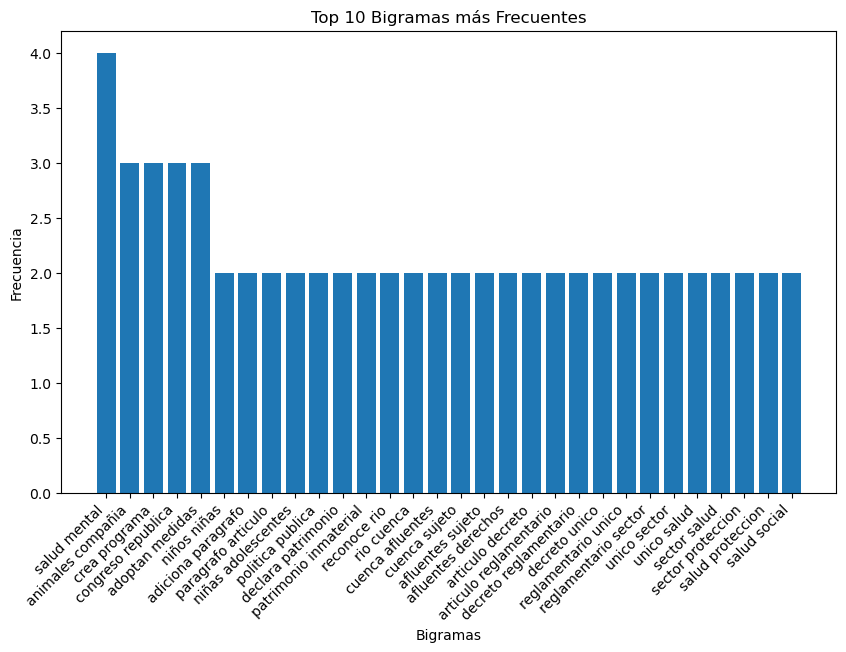

In [35]:
textos = ur.limpieza_de_textos(diccionario_ley_partido['Partido Conservador Colombiano'],data)
bigramas = []
for text in textos:
    if len(text.split())> 1:
        bigramas += ut.Generacion_de_skipgramas(text,2,1)
        
%matplotlib inline
ut.plot_bigramas(bigramas,30)
g_ley_pcc =  ut.creacion_del_grafo(ut.bigramas_para_grafo(bigramas,1))

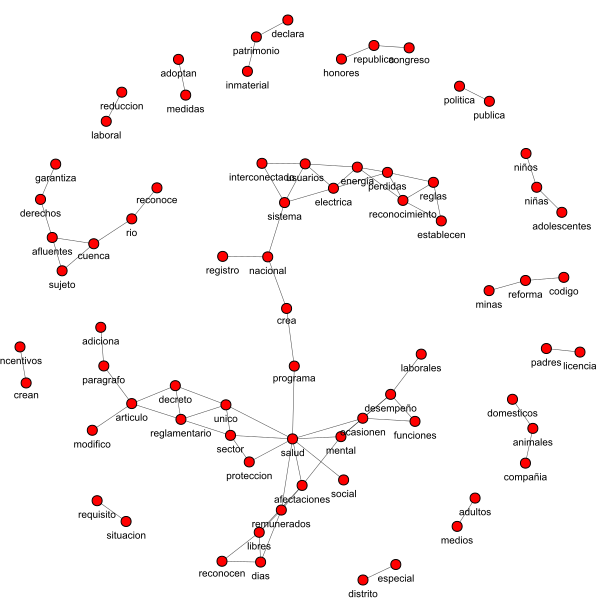

In [36]:
layout_pcc=g_ley_pcc.layout('fr')
ig.plot(g_ley_pcc,'../output/grafo_pcc_texto.png' ,layout=layout_pcc,vertex_size=10, bbox=(600,600),vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_label=g_ley_pcc.vs['name'],vertex_label_size=10)

In [78]:
ut.cluster_seleccion_componenteconexa_gigante(g_ley_pcc,'../output/g_ley_pcc_cluster.png','../output/g_ley_pcc_cluster_comunidades.png')

Comunidad 0: Palabra más importante (según grado): articulo
Comunidad 1: Palabra más importante (según grado): nacional
Comunidad 2: Palabra más importante (según grado): salud
Comunidad 3: Palabra más importante (según grado): libres
Comunidad 4: Palabra más importante (según grado): reconocimiento


In [82]:
ut.estadisticas_descriptivas(g_ley_pcc.connected_components().giant())

{'diametro': 13,
 'nodo_mayor_grado': ['salud'],
 'grado_mayor': 9,
 'nodo_mayor_fuerza': 'salud',
 'fuerza_mayor': 20.0,
 'nodo_centralidad_closeness': 'salud',
 'centralidad_closeness_mayor': 0.3142857142857143,
 'nodo_centralidad_betweenness': 'salud',
 'centralidad_betweenness_mayor': 380.34999999999997,
 'nodo_centralidad_eigen': 'salud',
 'centralidad_eigen_mayor': 1.0,
 'grado_promedio': 3.1176470588235294,
 'clan_mas_grande': 3,
 'densidad': 0.09447415329768272,
 'transitivity_Global': 0.39473684210526316}

In [75]:
palabras_mas_frecuentes(ur.limpieza_de_textos(diccionario_ley_partido['Partido Liberal'],data))

[('establece', 9),
 ('nacion', 9),
 ('municipio', 8),
 ('establecen', 7),
 ('declara', 7),
 ('departamento', 7),
 ('crea', 6),
 ('nacional', 6),
 ('colombia', 6),
 ('articulo', 6)]

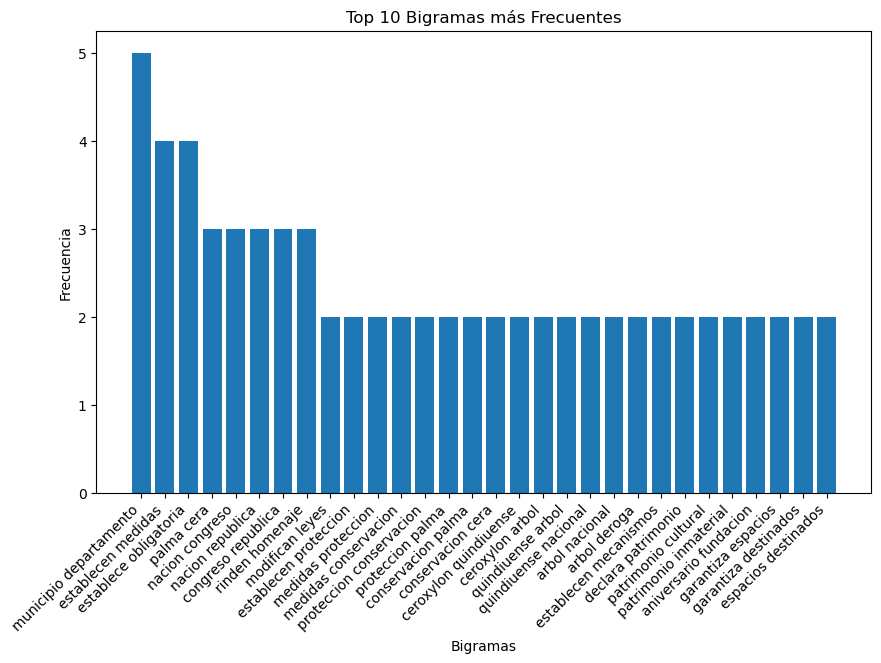

In [37]:
textos = ur.limpieza_de_textos(diccionario_ley_partido['Partido Liberal'],data)
bigramas = []
for text in textos:
    if len(text.split())> 1:
        bigramas += ut.Generacion_de_skipgramas(text,2,1)
        

ut.plot_bigramas(bigramas,30)
g_ley_pl =  ut.creacion_del_grafo(ut.bigramas_para_grafo(bigramas,1))

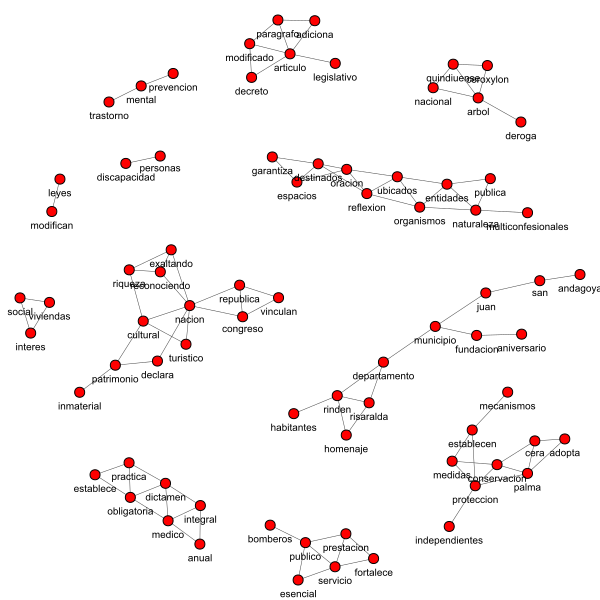

In [38]:
layout_pl=g_ley_pl.layout('fr')
ig.plot(g_ley_pl,'../output/grafo_pl_texto.png',layout=layout_pl,vertex_size=10, bbox=(600,600),vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_label=g_ley_pl.vs['name'],vertex_label_size=10)

In [79]:
ut.cluster_seleccion_componenteconexa_gigante(g_ley_pl,'../output/g_ley_pl_cluster.png','../output/g_ley_pl_cluster_comunidades.png')

Comunidad 0: Palabra más importante (según grado): patrimonio
Comunidad 1: Palabra más importante (según grado): nacion
Comunidad 2: Palabra más importante (según grado): congreso
Comunidad 3: Palabra más importante (según grado): exaltando


In [83]:
ut.estadisticas_descriptivas(g_ley_pl.connected_components().giant())


{'diametro': 5,
 'nodo_mayor_grado': ['nacion'],
 'grado_mayor': 7,
 'nodo_mayor_fuerza': 'nacion',
 'fuerza_mayor': 16.0,
 'nodo_centralidad_closeness': 'nacion',
 'centralidad_closeness_mayor': 0.6875,
 'nodo_centralidad_betweenness': 'nacion',
 'centralidad_betweenness_mayor': 33.916666666666664,
 'nodo_centralidad_eigen': 'nacion',
 'centralidad_eigen_mayor': 1.0,
 'grado_promedio': 3.0,
 'clan_mas_grande': 3,
 'densidad': 0.2727272727272727,
 'transitivity_Global': 0.3125}

In [76]:
palabras_mas_frecuentes(ur.limpieza_de_textos(diccionario_ley_partido['Centro Democrático'],data))

[('proteccion', 8),
 ('iva', 4),
 ('establecen', 4),
 ('derechos', 4),
 ('impuesto', 4),
 ('seguridad', 4),
 ('politica', 3),
 ('años', 3),
 ('medidas', 3),
 ('crea', 3)]

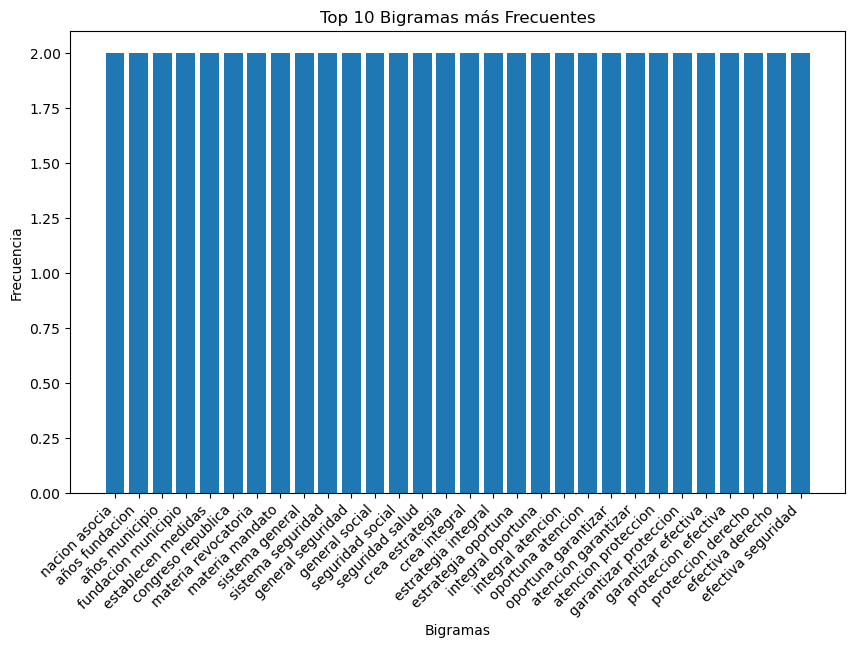

In [39]:
textos = ur.limpieza_de_textos(diccionario_ley_partido['Centro Democrático'],data)
bigramas = []
for text in textos:
    if len(text.split())> 1:
        bigramas += ut.Generacion_de_skipgramas(text,2,1)
        

ut.plot_bigramas(bigramas,30)
g_ley_cc =  ut.creacion_del_grafo(ut.bigramas_para_grafo(bigramas,1))

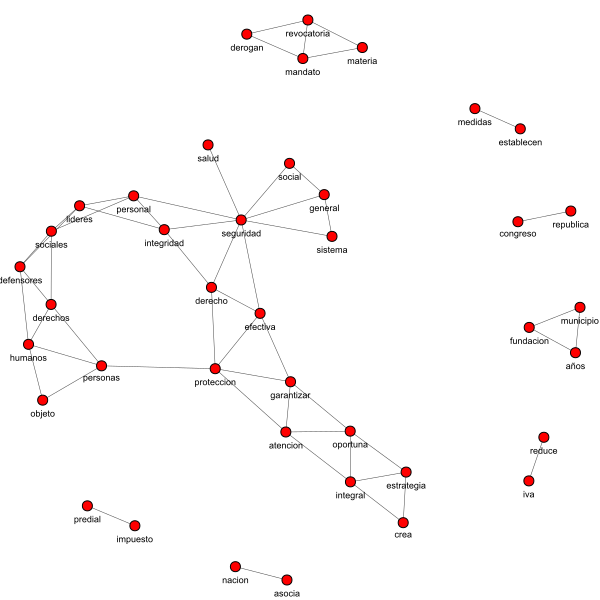

In [40]:
layout_cc=g_ley_cc.layout('fr')
ig.plot(g_ley_cc,'../output/grafo_cc_texto.png',layout=layout_cc,vertex_size=10, bbox=(600,600),vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_label=g_ley_cc.vs['name'],vertex_label_size=9)

In [80]:
ut.cluster_seleccion_componenteconexa_gigante(g_ley_cc,'../output/g_ley_cc_cluster.png','../output/g_ley_cc_cluster_comunidades.png')

Comunidad 0: Palabra más importante (según grado): seguridad
Comunidad 1: Palabra más importante (según grado): proteccion
Comunidad 2: Palabra más importante (según grado): integridad
Comunidad 3: Palabra más importante (según grado): defensores


In [84]:
ut.estadisticas_descriptivas(g_ley_cc.connected_components().giant())

{'diametro': 6,
 'nodo_mayor_grado': ['seguridad'],
 'grado_mayor': 8,
 'nodo_mayor_fuerza': 'seguridad',
 'fuerza_mayor': 16.0,
 'nodo_centralidad_closeness': 'proteccion',
 'centralidad_closeness_mayor': 0.4489795918367347,
 'nodo_centralidad_betweenness': 'seguridad',
 'centralidad_betweenness_mayor': 89.15,
 'nodo_centralidad_eigen': 'seguridad',
 'centralidad_eigen_mayor': 0.9999999999999999,
 'grado_promedio': 3.652173913043478,
 'clan_mas_grande': 3,
 'densidad': 0.1660079051383399,
 'transitivity_Global': 0.4318181818181818}

In [77]:
palabras_mas_frecuentes(ur.limpieza_de_textos(diccionario_ley_partido['Coalición Pacto Histórico'],data))

[('nacion', 6),
 ('colombia', 4),
 ('declara', 4),
 ('proyectos', 3),
 ('nacional', 3),
 ('colombiano', 3),
 ('rinde', 3),
 ('homenaje', 3),
 ('derechos', 3),
 ('amplia', 3)]

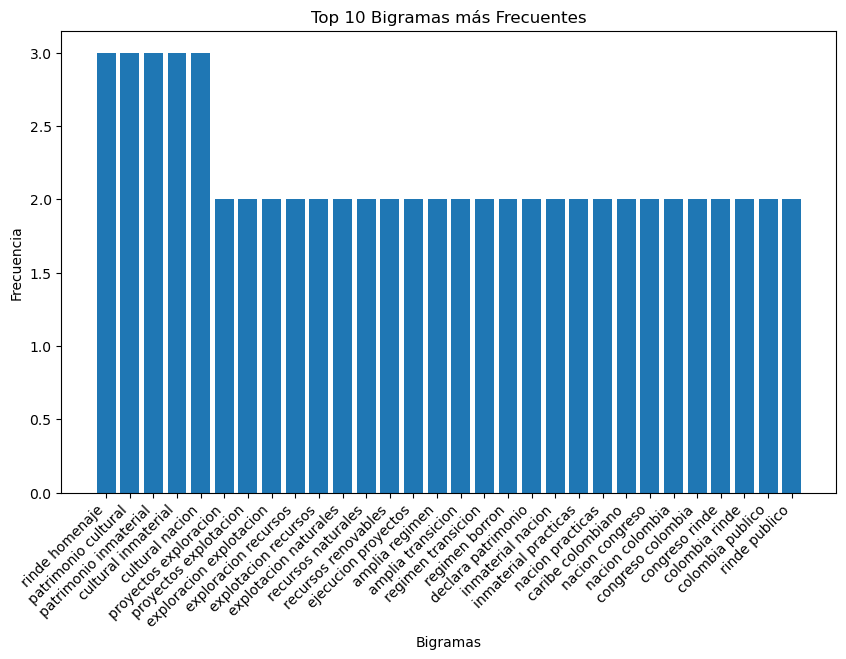

In [41]:
textos = ur.limpieza_de_textos(diccionario_ley_partido['Coalición Pacto Histórico'],data)
bigramas = []
for text in textos:
    if len(text.split())> 1:
        bigramas += ut.Generacion_de_skipgramas(text,2,1)
        

ut.plot_bigramas(bigramas,30)
g_ley_cph =  ut.creacion_del_grafo(ut.bigramas_para_grafo(bigramas,1))

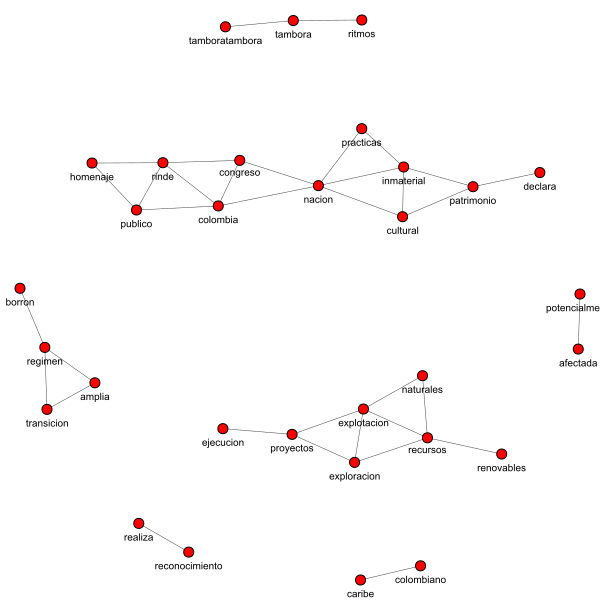

In [42]:
layout_cph=g_ley_cph.layout('fr')
ig.plot(g_ley_cph,'../output/grafo_cph_texto.png',layout=layout_cph,vertex_size=10, bbox=(600,600),vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_label=g_ley_cph.vs['name'],vertex_label_size=10)

In [81]:
ut.cluster_seleccion_componenteconexa_gigante(g_ley_cph,'../output/g_ley_cph_cluster.png','../output/g_ley_cph_cluster_comunidades.png')

Comunidad 0: Palabra más importante (según grado): rinde
Comunidad 1: Palabra más importante (según grado): nacion


In [85]:
ut.estadisticas_descriptivas(g_ley_cph.connected_components().giant())

{'diametro': 6,
 'nodo_mayor_grado': ['nacion'],
 'grado_mayor': 5,
 'nodo_mayor_fuerza': 'nacion',
 'fuerza_mayor': 11.0,
 'nodo_centralidad_closeness': 'nacion',
 'centralidad_closeness_mayor': 0.5882352941176471,
 'nodo_centralidad_betweenness': 'nacion',
 'centralidad_betweenness_mayor': 25.5,
 'nodo_centralidad_eigen': 'nacion',
 'centralidad_eigen_mayor': 0.9999999999999999,
 'grado_promedio': 3.090909090909091,
 'clan_mas_grande': 3,
 'densidad': 0.3090909090909091,
 'transitivity_Global': 0.5}

## todas las leyes partidos mas importantes 
Partidos
1. Partido Liberal                   306
2. Partido Conservador Colombiano    250
3. Partido Alianza Verde             237
4. Coalición Pacto Histórico         222

In [43]:
df_total=data_grafo.explode('Partidos')

In [44]:
diccionario_partido_total = df_total.groupby('Partidos')['Titulo'].apply(list).to_dict()

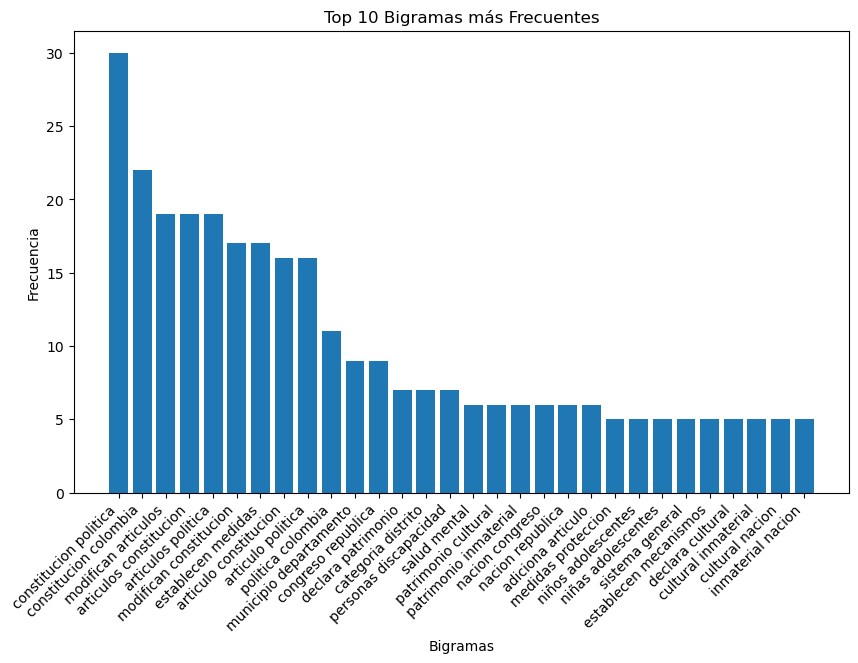

In [45]:
textos = ur.limpieza_de_textos(diccionario_partido_total['Partido Liberal'],data)
bigramas = []
for text in textos:
    if len(text.split())> 1:
        bigramas += ut.Generacion_de_skipgramas(text,2,1)
        
%matplotlib inline
ut.plot_bigramas(bigramas,30)
g_ley_pl_total =  ut.creacion_del_grafo(ut.bigramas_para_grafo(bigramas,2))

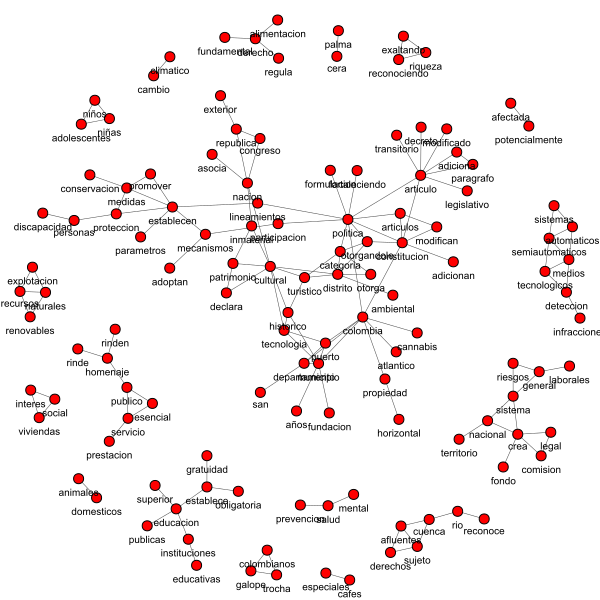

In [46]:
layout_pl=g_ley_pl_total.layout('fr')
ig.plot(g_ley_pl_total,'../output/grafo_pl_texto_total.png',layout=layout_pl,vertex_size=10, bbox=(600,600),vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_label=g_ley_pl_total.vs['name'],vertex_label_size=10)

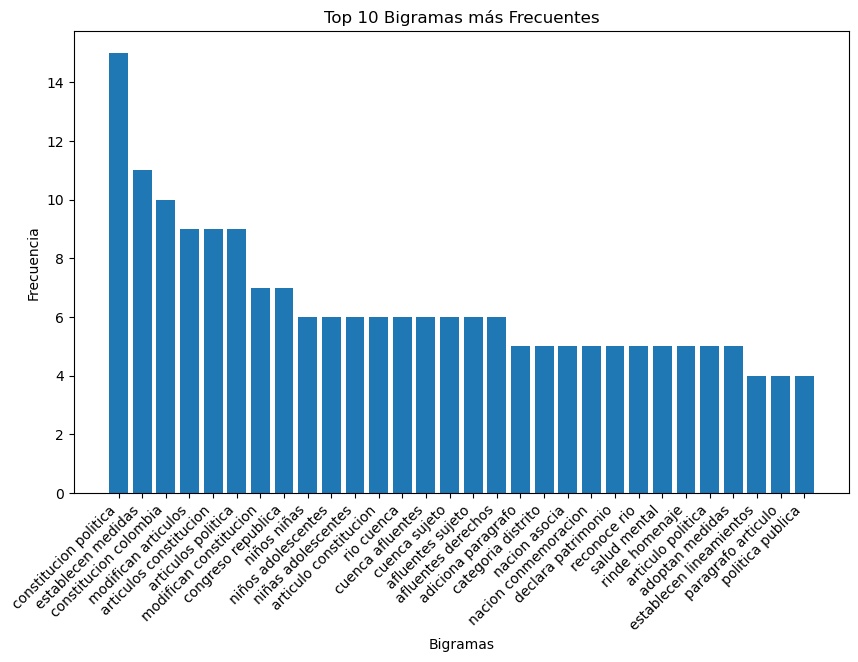

In [47]:
textos = ur.limpieza_de_textos(diccionario_partido_total['Partido Conservador Colombiano'],data)
bigramas = []
for text in textos:
    if len(text.split())> 1:
        bigramas += ut.Generacion_de_skipgramas(text,2,1)
        
%matplotlib inline
ut.plot_bigramas(bigramas,30)
g_ley_pcc_total =  ut.creacion_del_grafo(ut.bigramas_para_grafo(bigramas,2))

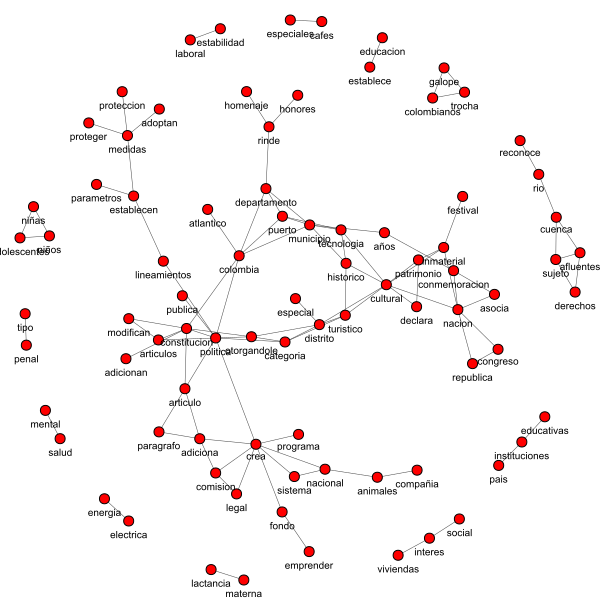

In [48]:
layout_pcc=g_ley_pcc_total.layout('fr')
ig.plot(g_ley_pcc_total,'../output/grafo_pcc_texto_total.png',layout=layout_pcc,vertex_size=10, bbox=(600,600),vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_label=g_ley_pcc_total.vs['name'],vertex_label_size=10)

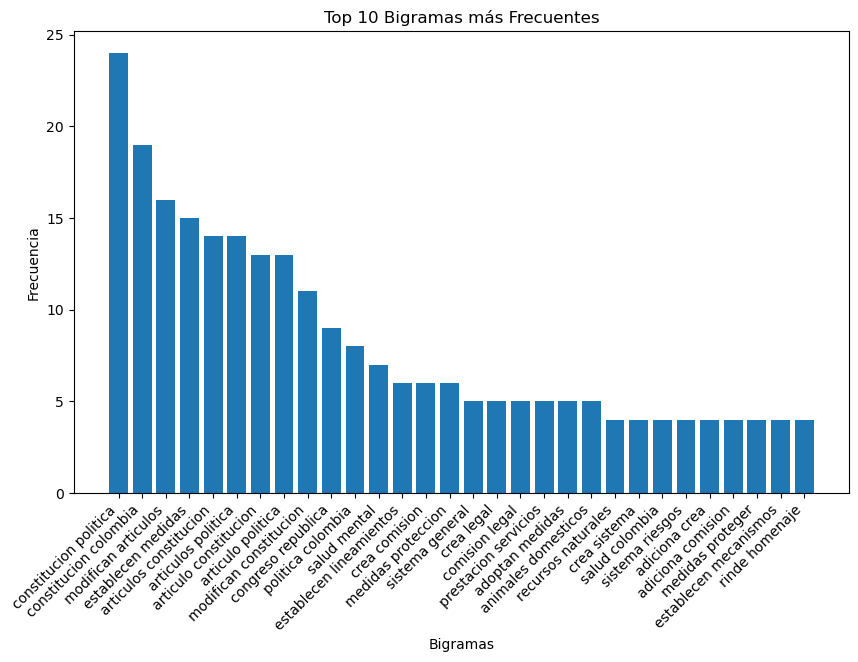

In [49]:
textos = ur.limpieza_de_textos(diccionario_partido_total['Partido Alianza Verde'],data)
bigramas = []
for text in textos:
    if len(text.split())> 1:
        bigramas += ut.Generacion_de_skipgramas(text,2,1)
        
%matplotlib inline
ut.plot_bigramas(bigramas,30)
g_ley_pav_total =  ut.creacion_del_grafo(ut.bigramas_para_grafo(bigramas,2))

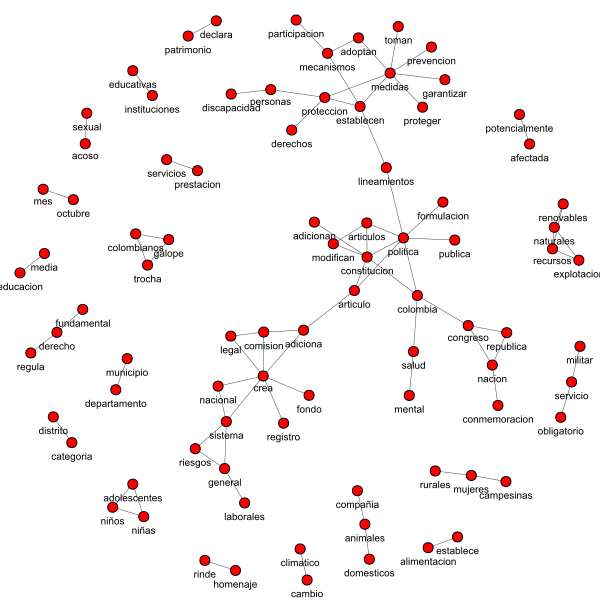

In [50]:
layout_pav=g_ley_pav_total.layout('fr')
ig.plot(g_ley_pav_total,'../output/grafo_pav_texto_total.png',layout=layout_pav,vertex_size=10, bbox=(600,600),vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_label=g_ley_pav_total.vs['name'],vertex_label_size=10)

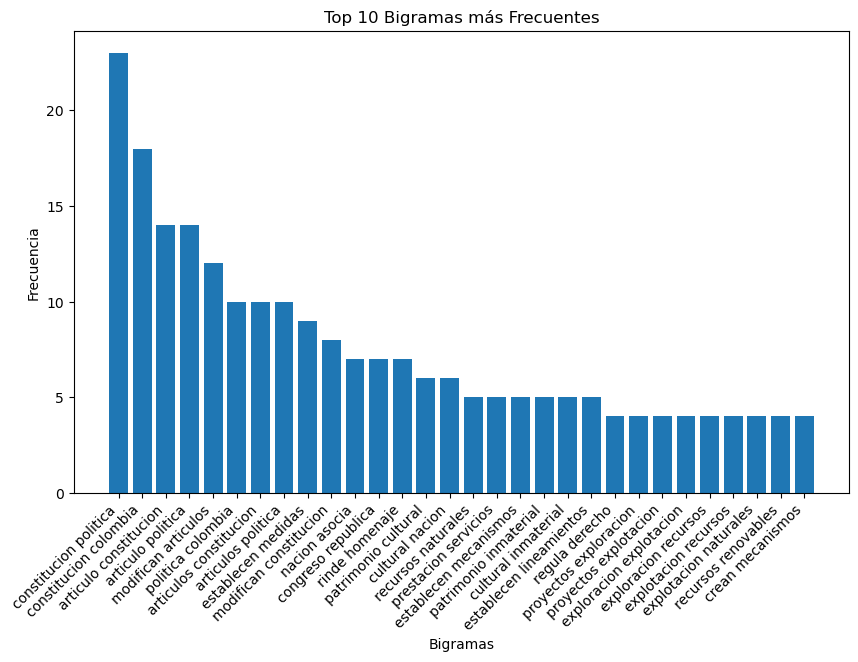

In [51]:
textos = ur.limpieza_de_textos(diccionario_partido_total['Coalición Pacto Histórico'],data)
bigramas = []
for text in textos:
    if len(text.split())> 1:
        bigramas += ut.Generacion_de_skipgramas(text,2,1)
        
%matplotlib inline
ut.plot_bigramas(bigramas,30)
g_ley_cph_total =  ut.creacion_del_grafo(ut.bigramas_para_grafo(bigramas,2))

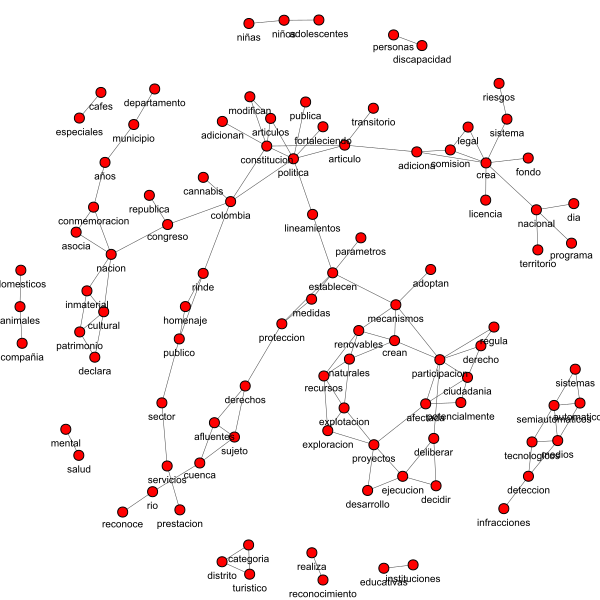

In [52]:
layout_cph=g_ley_cph_total.layout('fr')
ig.plot(g_ley_cph_total,'../output/grafo_cph_texto_total.png',layout=layout_cph,vertex_size=10, bbox=(600,600),vertex_label_dist=2,edge_arrow_size=0.5,edge_width=0.5,vertex_label=g_ley_cph_total.vs['name'],vertex_label_size=10)

### cluster y analsis de comunidades

In [53]:
ut.cluster_seleccion_componenteconexa_gigante(g_ley_pl_total,'../output/grafo_pl_texto_total_cluster.png','../output/grafo_pl_texto_total_cluster_comunidades.png')

Comunidad 0: Palabra más importante (según grado): articulo
Comunidad 1: Palabra más importante (según grado): politica
Comunidad 2: Palabra más importante (según grado): colombia
Comunidad 3: Palabra más importante (según grado): establecen
Comunidad 4: Palabra más importante (según grado): nacion
Comunidad 5: Palabra más importante (según grado): cultural


In [86]:
ut.estadisticas_descriptivas(g_ley_pl_total.connected_components().giant())

{'diametro': 11,
 'nodo_mayor_grado': ['politica'],
 'grado_mayor': 10,
 'nodo_mayor_fuerza': 'constitucion',
 'fuerza_mayor': 110.0,
 'nodo_centralidad_closeness': 'politica',
 'centralidad_closeness_mayor': 0.38686131386861317,
 'nodo_centralidad_betweenness': 'politica',
 'centralidad_betweenness_mayor': 758.9095238095239,
 'nodo_centralidad_eigen': 'politica',
 'centralidad_eigen_mayor': 1.0,
 'grado_promedio': 2.925925925925926,
 'clan_mas_grande': 4,
 'densidad': 0.05520614954577219,
 'transitivity_Global': 0.2568493150684932}

In [54]:
ut.cluster_seleccion_componenteconexa_gigante(g_ley_pcc_total,'../output/grafo_pcc_texto_total_cluster.png','../output/grafo_pcc_texto_total_cluster_comunidades.png')

Comunidad 0: Palabra más importante (según grado): medidas
Comunidad 1: Palabra más importante (según grado): crea
Comunidad 2: Palabra más importante (según grado): politica
Comunidad 3: Palabra más importante (según grado): colombia
Comunidad 4: Palabra más importante (según grado): cultural
Comunidad 5: Palabra más importante (según grado): rinde


In [87]:
ut.estadisticas_descriptivas(g_ley_pcc_total.connected_components().giant())

{'diametro': 9,
 'nodo_mayor_grado': ['politica'],
 'grado_mayor': 9,
 'nodo_mayor_fuerza': 'constitucion',
 'fuerza_mayor': 53.0,
 'nodo_centralidad_closeness': 'politica',
 'centralidad_closeness_mayor': 0.3722627737226277,
 'nodo_centralidad_betweenness': 'politica',
 'centralidad_betweenness_mayor': 747.0095238095237,
 'nodo_centralidad_eigen': 'politica',
 'centralidad_eigen_mayor': 1.0,
 'grado_promedio': 3.0384615384615383,
 'clan_mas_grande': 4,
 'densidad': 0.059577677224736045,
 'transitivity_Global': 0.29213483146067415}

In [55]:
ut.cluster_seleccion_componenteconexa_gigante(g_ley_pav_total,'../output/grafo_pav_texto_total_cluster.png','../output/grafo_pav_texto_total_cluster_comunidades.png')

Comunidad 0: Palabra más importante (según grado): politica
Comunidad 1: Palabra más importante (según grado): medidas
Comunidad 2: Palabra más importante (según grado): crea
Comunidad 3: Palabra más importante (según grado): sistema
Comunidad 4: Palabra más importante (según grado): congreso


In [88]:
ut.estadisticas_descriptivas(g_ley_pav_total.connected_components().giant())

{'diametro': 11,
 'nodo_mayor_grado': ['politica', 'crea', 'medidas'],
 'grado_mayor': 7,
 'nodo_mayor_fuerza': 'constitucion',
 'fuerza_mayor': 86.0,
 'nodo_centralidad_closeness': 'politica',
 'centralidad_closeness_mayor': 0.325,
 'nodo_centralidad_betweenness': 'politica',
 'centralidad_betweenness_mayor': 448.5,
 'nodo_centralidad_eigen': 'politica',
 'centralidad_eigen_mayor': 1.0,
 'grado_promedio': 2.5,
 'clan_mas_grande': 3,
 'densidad': 0.0641025641025641,
 'transitivity_Global': 0.2222222222222222}

In [56]:
ut.cluster_seleccion_componenteconexa_gigante(g_ley_cph_total,'../output/grafo_cph_texto_total_cluster.png','../output/grafo_cph_texto_total_cluster_comunidades.png')

Comunidad 0: Palabra más importante (según grado): politica
Comunidad 1: Palabra más importante (según grado): participacion
Comunidad 2: Palabra más importante (según grado): proyectos
Comunidad 3: Palabra más importante (según grado): mecanismos
Comunidad 4: Palabra más importante (según grado): publico
Comunidad 5: Palabra más importante (según grado): nacion
Comunidad 6: Palabra más importante (según grado): establecen
Comunidad 7: Palabra más importante (según grado): crea
Comunidad 8: Palabra más importante (según grado): nacional
Comunidad 9: Palabra más importante (según grado): derechos


In [89]:
ut.estadisticas_descriptivas(g_ley_cph_total.connected_components().giant())

{'diametro': 15,
 'nodo_mayor_grado': ['politica', 'participacion', 'crea'],
 'grado_mayor': 7,
 'nodo_mayor_fuerza': 'constitucion',
 'fuerza_mayor': 76.0,
 'nodo_centralidad_closeness': 'politica',
 'centralidad_closeness_mayor': 0.2491103202846975,
 'nodo_centralidad_betweenness': 'politica',
 'centralidad_betweenness_mayor': 1434.0,
 'nodo_centralidad_eigen': 'participacion',
 'centralidad_eigen_mayor': 1.0,
 'grado_promedio': 2.788732394366197,
 'clan_mas_grande': 3,
 'densidad': 0.03983903420523138,
 'transitivity_Global': 0.30916030534351147}

# red de similaridad semantica entre leyes unicas

In [57]:
# embeddings resultantes del modelo sentence bert
with h5py.File('../input/embeddings.h5', 'r') as f:
    embeddings = f['embeddings'][:]

In [58]:
embeddings.shape

(211, 768)

In [59]:
# matriz de adyacencia (similaridad) para la red
matriz = cosine_similarity(embeddings)
np.fill_diagonal(matriz, 0)

In [60]:
# creacion del grafo con umbrales 
G_similaridad = ut.create_graph_from_similarity_matrix(matriz, 0.6,-0.5)

In [61]:
# vector de propiedades 
partidos_graph = ['Partido Conservador Colombiano']*86+['Partido Liberal']*59+['Centro Democrático']*35+['Coalición Pacto Histórico']*31

In [62]:
#nombre de las leyes
name = list(datos_pu[datos_pu['Partidos']=='Partido Conservador Colombiano']['No Camara'])+list(datos_pu[datos_pu['Partidos']=='Partido Liberal']['No Camara'])+list(datos_pu[datos_pu['Partidos']=='Centro Democrático']['No Camara'])+list(datos_pu[datos_pu['Partidos']=='Coalición Pacto Histórico']['No Camara'])

In [63]:
# añadir propiedades al grafo
G_similaridad.vs['partido'] = partidos_graph
G_similaridad.vs['name'] = name

In [64]:
G_similaridad.summary()

'IGRAPH UNW- 210 1644 -- \n+ attr: name (v), partido (v), weight (e)'

In [65]:
def plot_node_strength_distribution(graph):
    # Crear el histograma de la fuerza de los nodos
    node_strengths = graph.strength(weights='weight')
    plt.figure(figsize=(10, 6))
    plt.hist(node_strengths, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Distribución de la Fuerza de los Nodos')
    plt.xlabel('Fuerza del Nodo')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

def plot_node_degree_distribution(graph):
    # Crear el histograma de la fuerza de los nodos
    node_strengths = graph.degree()
    plt.figure(figsize=(10, 6))
    plt.hist(node_strengths, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Distribución del grado de los Nodos')
    plt.xlabel('Grado del Nodo')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

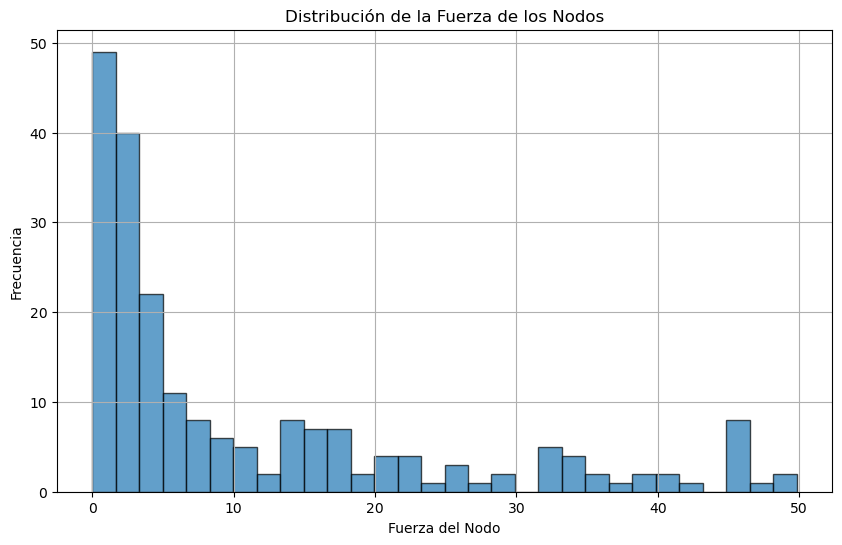

In [66]:
plot_node_strength_distribution(G_similaridad)

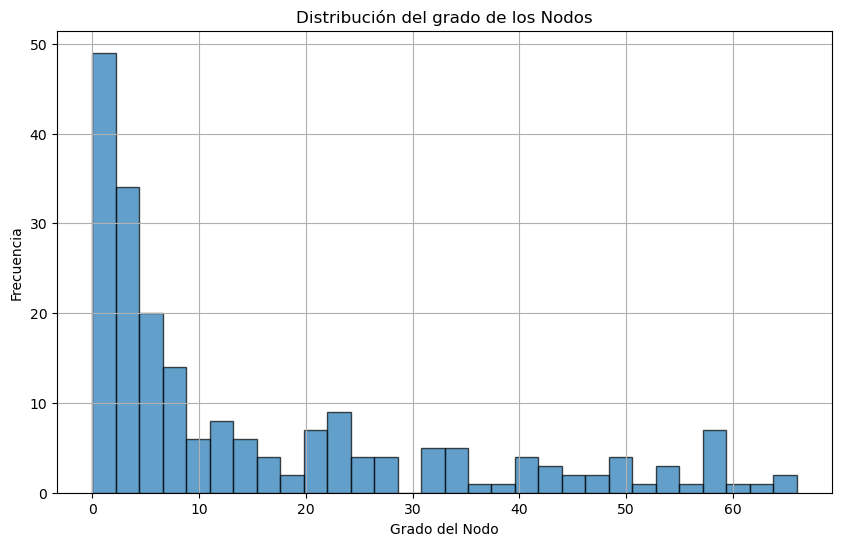

In [67]:
plot_node_degree_distribution(G_similaridad)

In [68]:
# estadisticas basicas
ut.estadisticas_descriptivas(G_similaridad)

{'diametro': 7,
 'nodo_mayor_grado': ['412/2023C', '234/2023C'],
 'grado_mayor': 66,
 'nodo_mayor_fuerza': '412/2023C',
 'fuerza_mayor': 49.83086955547333,
 'nodo_centralidad_closeness': '154/2022C',
 'centralidad_closeness_mayor': 1.0,
 'nodo_centralidad_betweenness': '266/2023C',
 'centralidad_betweenness_mayor': 2326.369823679068,
 'nodo_centralidad_eigen': '234/2023C',
 'centralidad_eigen_mayor': 1.0,
 'grado_promedio': 15.657142857142857,
 'clan_mas_grande': 30,
 'densidad': 0.07491455912508543,
 'transitivity_Global': 0.6578218856098198}

In [69]:
print('nodos de mayor grado:',datos_pu[datos_pu['No Camara']=='412/2023C'].values,datos_pu[datos_pu['No Camara']=='234/2023C'].values,'\n',
      'nodo de mayor fuerza:',datos_pu[datos_pu['No Camara']=='412/2023C'].values,"\n",
      'nodo con mayor betweeness:',datos_pu[datos_pu['No Camara']=='266/2023C'].values,"\n",
      'nodo con mayor closeness:',datos_pu[datos_pu['No Camara']=='276/2022C'].values)

nodos de mayor grado: [['PRACTICAS INCRUENTAS'
  'Por medio de la cual se modifica la ley 916 de 2004, se reglamentan las Corralejas y se dictan otras dis-posiciones'
  '412/2023C' None list(['HR. Oscar Leonardo Villamizar Meneses'])
  'http://svrpubindc.imprenta.gov.co/senado/index2.xhtml?ent=Cámara&fec=2-6-2023&num=614'
  'https://www.camara.gov.co/practicas-incruentas' '2022 - 2023'
  'Archivado' 'Ley Ordinaria' 'Centro Democrático']] [['PRÁCTICAS INCONGRUENTES'
  'Por medio de la cual se modifica la ley 916 de 2004, se reglamentan las Corralejas y se dictan otras disposiciones'
  '234/2023C' None list(['HR. Oscar Leonardo Villamizar Meneses'])
  'http://svrpubindc.imprenta.gov.co/senado/'
  'https://www.camara.gov.co/practicas-incongruentes' '2023 - 2024'
  'Trámite en Comisión' 'Ley Ordinaria' 'Centro Democrático']] 
 nodo de mayor fuerza: [['PRACTICAS INCRUENTAS'
  'Por medio de la cual se modifica la ley 916 de 2004, se reglamentan las Corralejas y se dictan otras dis-posiciones

In [70]:
# guardamos el grafo para modelado
G_similaridad.write_graphml("../input/graph_similaridad.graphml")